# **Project Akhir Aldiansah Permana**

# **Movie Recommendation System**

# **Business Understanding**
## **Problem Statements**
* Bagaimana cara meningkatkan user experience saat mencari film yang ingin ditonton?
* Bagaimana cara membuat sistem rekomendasi film menggunakan metode collaborative filtering?

## **Goals**
Meningkatakan user experience saat mencari film yang ingin ditonton.

## **Solution statements**
Dataset yang digunakan hanya berisi tentang rating atau hasil penilaian pengguna dan genre film, maka solusi yang sangat tepat untuk masalah ini adalah dengan menggunakan collaborative filtering.
[Collaborative Filtering](https://medium.com/@ranggaantok/bagaimana-sistem-rekomendasi-berkerja-e749dac64816): collaborative filtering adalah suatu konsep dimana opini dari pengguna lain yang ada digunakan untuk memprediksi item yang mungkin disukai/diminati oleh seorang pengguna.
Pada collaborative filtering attribut yang digunakan bukan konten tetapi user behaviour. contohnya kita merekomendasikan suatu item berdasarkan dari riwayat rating dari user tersebut maupun user lain.

![image](https://miro.medium.com/max/335/1*O6ON-kQ34pMCYOHSr7ZebQ.png)

# **Instalasi Kaggle**

# Import kaggle untuk mengambil data

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aldiansahpermana","key":"48c160f2a5c05b0ce452dda0169cb9d4"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

# Mengunduh dataset dari platform kaggle.com

In [4]:
!kaggle datasets download -d aigamer/movie-lens-dataset

  0% 0.00/967k [00:00<?, ?B/s]
100% 967k/967k [00:00<00:00, 96.7MB/s]


# **Import Library**

In [5]:
import os
import zipfile
import numpy as np
import pandas as pd
import nltk
import keras
import tensorflow as tf
import seaborn as sns
from keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau


# **Data Understanding**

# Ekstrak data

In [6]:
local_zip = '/content/movie-lens-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Membuat dataframe

In [7]:
movie_df = pd.read_csv('/content/movies.csv')
rating_df = pd.read_csv('/content/ratings.csv')
tags_df = pd.read_csv('/content/tags.csv')

# Informasi Data

In [8]:
movie_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [9]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [10]:
movie_df.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [11]:
rating_df = rating_df.drop(['timestamp'],axis=1)
rating_df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [12]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [13]:
rating_df.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [14]:
tags_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [15]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [16]:
tags_df.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

# Menghapus missing value

In [18]:
movie_df = movie_df.dropna()
rating_df = rating_df.dropna()
tags_df = tags_df.dropna()

# Informasi Data

In [19]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


# Menggabungkan dataframe rating dan movie

In [20]:
new_movie_df = rating_df.merge(movie_df,how='inner',on='movieId')
new_movie_df.tail()

,userId,movieId,rating,title,genres
100831,610,160341,2.5,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,Blair Witch (2016),Horror|Thriller
100835,610,163981,3.5,31 (2016),Horror


# Normalisasi kolom rating

In [21]:
minRating = min(rating_df['rating'])
maxRating = max(rating_df['rating'])
rating_df['rating'] = rating_df["rating"].apply(lambda x: (x - minRating) / (maxRating - minRating)).values.astype(np.float32)
AvgRating = np.mean(rating_df['rating'])

# Menampilkan rata-rata rating

In [22]:
print('Average Rating: ', AvgRating)

Average Rating:  0.6670127


# Memberikan id baru pada setiap baris di dataframe

In [23]:
# Membuat unique value dari userId
userIds = rating_df["userId"].unique().tolist()
# Membuat nilai sama dengan jumlah userID
encodedUser = {x: i for i, x in enumerate(userIds)}
encodeusertouser = {i: x for i, x in enumerate(userIds)}

In [24]:
# Membuat kolom user yang nilainya dihasilkan berdasarkan peroses generate nilai userId.
rating_df["user"] = rating_df["userId"].map(encodedUser)
nUsers = len(encodedUser)

In [25]:
# Membuat kolom user yang nilainya dihasilkan berdasarkan peroses generate nilai movieId.
movieIds = rating_df["movieId"].unique().tolist()
firstMovieEncoder = {x: i for i, x in enumerate(movieIds)}
movieEncoder = {i: x for i, x in enumerate(movieIds)}
rating_df["movie"] = rating_df["movieId"].map(firstMovieEncoder)
nMovie = len(firstMovieEncoder)

In [26]:
rating_df

,userId,movieId,rating,user,movie
0,1,1,0.777778,0,0
1,1,3,0.777778,0,1
2,1,6,0.777778,0,2
3,1,47,1.000000,0,3
4,1,50,1.000000,0,4
...,...,...,...,...,...
100831,610,166534,0.777778,609,3120
100832,610,168248,1.000000,609,2035
100833,610,168250,1.000000,609,3121
100834,610,168252,1.000000,609,1392


In [27]:
print("Num of users: {}, Num of movie: {}".format(nUsers, nMovie))
print("Min rating: {}, Max rating: {}".format(min(rating_df['rating']), max(rating_df['rating'])))

Num of users: 610, Num of movie: 9724
Min rating: 0.0, Max rating: 1.0


# Membagi jumlah data yang akan digunakan untuk proses training dan proses testing

In [28]:
# Mengacak sampel data
rating_df = rating_df.sample(frac=1, random_state=73)

X = rating_df[['user', 'movie']].values
Y = rating_df["rating"]

In [29]:
# Membagi data yang akan digunakan
test_size = 200000
train_indices = rating_df.shape[0] - test_size
X_train, X_test, Y_train, Y_test = (X[:train_indices], X[train_indices:], Y[:train_indices], Y[train_indices:])


In [30]:
# Membagi X_train dan X_test untuk melatih model
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

# Pembuatan arsitektur model dengan menggunakan embedding layer

In [31]:
def model_preparation():
    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding', input_dim = nUsers, output_dim = 128)(user)

    movie = Input(name = 'movie', shape = [1])
    movie_embed = Embedding(name = 'movie_embedding', input_dim = nMovie, output_dim = 128)(movie)

    # Model mengguanakan layer Dot yang digunakan untuk komputasi antara embedding dari anime dan dari user.
    x = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, movie_embed])
    x = Flatten()(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, movie], outputs=x)
    model.compile(
        loss='binary_crossentropy',
        metrics=["mse", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
        optimizer='Adam')

    return model

In [32]:
model = model_preparation()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 128)       78080       ['user[0][0]']                   
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 128)       1244672     ['movie[0][0]']                  
                                                                                              

# Melakukan training model Embedding

In [33]:
# Menyimpan model terbaik dari proses training model.
best_model = ModelCheckpoint(
    filepath='./weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [35]:
# Menghentikan proses training model apabila metrik mse tidak mengalami penurunan.
early_stopping = EarlyStopping(patience = 1, monitor='mse', mode='min', restore_best_weights=True)

my_callbacks = [
    best_model,
    early_stopping,
]

# Training model

In [36]:
hist = model.fit(
    x=X_train_array,
    y=Y_train,
    validation_data=(X_test_array, Y_test),
    epochs=30,
    batch_size=64,
    verbose=1,
    callbacks=my_callbacks,
)

Epoch 1/30
27/27 [==============================] - 8s 241ms/step - loss: 0.7882 - mse: 0.1174 - precision: 0.9882 - recall: 0.5085 - val_loss: 0.6895 - val_mse: 0.0798 - val_precision: 0.9866 - val_recall: 0.6334
Epoch 2/30
27/27 [==============================] - 3s 121ms/step - loss: 0.6230 - mse: 0.0444 - precision: 1.0000 - recall: 0.5363 - val_loss: 0.6861 - val_mse: 0.0781 - val_precision: 0.9865 - val_recall: 0.7114
Epoch 3/30
27/27 [==============================] - 3s 124ms/step - loss: 0.5860 - mse: 0.0289 - precision: 1.0000 - recall: 0.5569 - val_loss: 0.6836 - val_mse: 0.0768 - val_precision: 0.9863 - val_recall: 0.7474
Epoch 4/30
27/27 [==============================] - 6s 229ms/step - loss: 0.5745 - mse: 0.0242 - precision: 1.0000 - recall: 0.5738 - val_loss: 0.6815 - val_mse: 0.0758 - val_precision: 0.9863 - val_recall: 0.7679
Epoch 5/30
27/27 [==============================] - 3s 118ms/step - loss: 0.5659 - mse: 0.0208 - precision: 1.0000 - recall: 0.5890 - val_loss: 

In [37]:
model.load_weights('./weights.h5')

# **Membuat Plot**

# Menampilkan plot loss

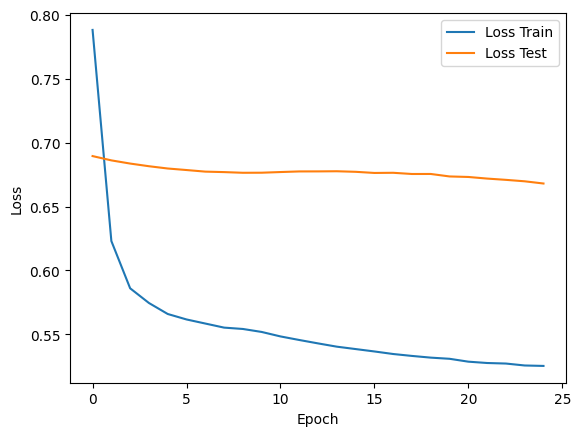

In [38]:
# Membuat plot loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss Train', 'Loss Test'], loc='upper right')
plt.show()

# Menampilkan plot mse

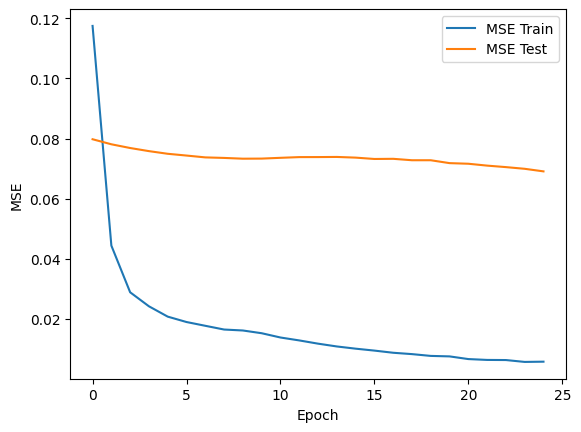

In [39]:
# Membuat plot mse
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['MSE Train', 'MSE Test'], loc='upper right')
plt.show()

# Menampilkan plot recall

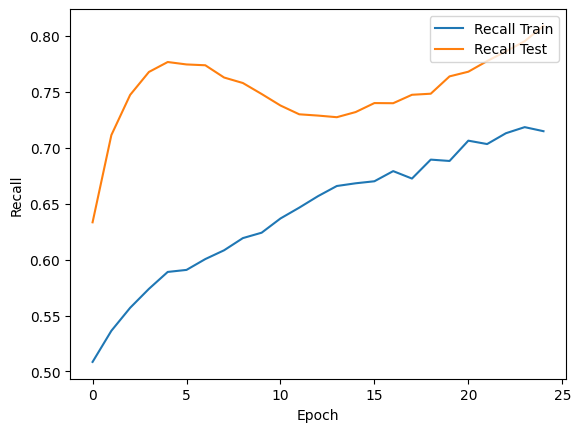

In [40]:
# Membuat plot recall
plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Recall Train', 'Recall Test'], loc='upper right')
plt.show()

# Menampilkan plot precision

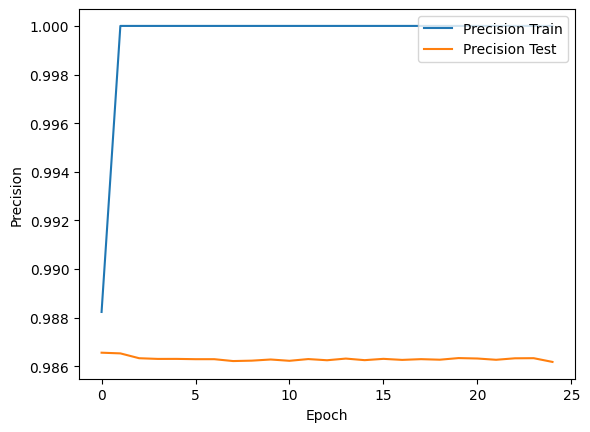

In [41]:
# Membuat plot precision
plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Precision Train', 'Precision Test'], loc='upper right')
plt.show()

# **Load model**

# Melakukan load kembali weight model yang sebelumnya telah disimpan

In [42]:
def load_weight(name, model):
    weights = model.get_layer(name).get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

In [43]:
movie_weights = load_weight('movie_embedding', model)
user_weights = load_weight('user_embedding', model)

# Mencari MovieId berdasarkan judul

In [44]:
def movie_data(movie):
    if isinstance(movie, int):
        return movie_df[movie_df.movieId == movie]
    if isinstance(anime, str):
        return movie_df[movie_df.title == movie]

## **Collaborative Filtering**

# Generate random user

In [45]:
rating_by_user = rating_df.groupby('userId').size()
random_user = rating_by_user[rating_by_user < 1000].sample(1, random_state=None).index[0]
# Memasukkan id user secara random
print('User ID:', random_user)
top_movie_user = new_movie_df.groupby('userId').get_group(random_user)
top_movie_user[['rating', 'title', 'genres']].sort_values(
    by = 'rating',
    ascending=False
)

User ID: 175


,rating,title,genres
91934,5.0,Step Up (2006),Drama|Romance
91932,5.0,Take the Lead (2006),Drama
41344,5.0,Chasing Liberty (2004),Comedy|Romance
91918,5.0,Raise Your Voice (2004),Romance
91058,5.0,Ice Princess (2005),Children|Comedy|Drama
39514,5.0,Goal! The Dream Begins (Goal!) (2005),Drama
63952,5.0,Center Stage (2000),Drama|Musical
71367,5.0,Footloose (1984),Drama
78029,4.5,Pay It Forward (2000),Drama
88137,4.5,"Cinderella Story, A (2004)",Comedy|Romance


# Mencari tingkat kemiripan user

In [46]:
def get_similar_users(tempId, n=10):
      index = tempId
      weights = user_weights
      dists = np.dot(weights, weights[encodedUser.get(index)])
      sortedDists = np.argsort(dists)
      n += 1
      closest = sortedDists[-n:]
      print('User that similar to user #{}'.format(tempId))

      SimilarArr = []

      for close in closest:
          similarity = dists[closest]

          if isinstance(tempId, int):
              SimilarArr.append({"similar_users": encodeusertouser.get(close), "similarity": similarity})

      Frame = pd.DataFrame(SimilarArr)
      return Frame

# Mencari pengguna yang serupa

In [47]:
similar_users = get_similar_users(int(random_user), n=10)
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users

User that similar to user #175


,similar_users,similarity
0,100,"[0.19105974, 0.19109485, 0.19133145, 0.1957566..."
1,382,"[0.19105974, 0.19109485, 0.19133145, 0.1957566..."
2,424,"[0.19105974, 0.19109485, 0.19133145, 0.1957566..."
3,478,"[0.19105974, 0.19109485, 0.19133145, 0.1957566..."
4,524,"[0.19105974, 0.19109485, 0.19133145, 0.1957566..."
5,302,"[0.19105974, 0.19109485, 0.19133145, 0.1957566..."
6,498,"[0.19105974, 0.19109485, 0.19133145, 0.1957566..."
7,476,"[0.19105974, 0.19109485, 0.19133145, 0.1957566..."
8,161,"[0.19105974, 0.19109485, 0.19133145, 0.1957566..."
9,479,"[0.19105974, 0.19109485, 0.19133145, 0.1957566..."


# Menampilkan list rekomendasi movie berdasarkan aktivitas tontonan movie pengguna

In [50]:
def get_user_movie_preference(userId, plot=False, temp=1):
  # Menentukan batas rating terendah movie
  lowest_rating = np.percentile(rating_df[rating_df.userId==userId].rating, 75)
  rating_df[rating_df.userId==userId] = rating_df[rating_df.userId==userId][rating_df[rating_df.userId==userId].rating >= lowest_rating]
  top_movie_refference = (
      rating_df[rating_df.userId==userId].sort_values(by="rating", ascending=False)
      .movieId.values
  )
  user_pref_df = movie_df[movie_df["movieId"].isin(top_movie_refference)]
  user_pref_df = user_pref_df[["movieId","title", "genres"]]

  if temp != 0:
      print("User #{} Already Rated {} movies with average rating = {:.1f}/5.0".format(
        userId, len(rating_df[rating_df.userId==userId]),
        rating_df[rating_df.userId==userId]['rating'].mean()*5,
      ))
      print('Recommended movie genre for user:')

  return user_pref_df


# Menampilkan 10 rekomendasi movie untuk pengguna

In [51]:
reff_user = get_user_movie_preference(random_user, plot=True)
reff_user=pd.DataFrame(reff_user)
reff_user.head(10)

User #175 Already Rated 8 movies with average rating = 5.0/5.0
Recommended movie genre for user:


,movieId,title,genres
2684,3594,Center Stage (2000),Drama|Musical
2834,3791,Footloose (1984),Drama
4812,7169,Chasing Liberty (2004),Comedy|Romance
5345,8911,Raise Your Voice (2004),Romance
5829,32289,Ice Princess (2005),Children|Comedy|Drama
6023,38388,Goal! The Dream Begins (Goal!) (2005),Drama
6167,44613,Take the Lead (2006),Drama
6265,47382,Step Up (2006),Drama|Romance
